In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [3]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])



In [4]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [5]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
1338729,2025-03-16 19:23:33 UTC,irajoskaya,bb,267,251
1338730,2025-03-16 19:23:34 UTC,banties_x,okak,267,199
1338731,2025-03-16 19:23:35 UTC,sir_a7md_,byyyyyyyyyye,267,251
1338732,2025-03-16 19:23:35 UTC,kane_ong,2020ByeGuys,267,190
1338733,2025-03-16 19:23:35 UTC,catsspurr,bye,267,130
1338734,2025-03-16 19:23:35 UTC,ASSpaperman,bye bye,267,232
1338735,2025-03-16 19:23:36 UTC,sov0z,o7,267,264
1338736,2025-03-16 19:23:36 UTC,elluiti,bye,267,81
1338737,2025-03-16 19:23:36 UTC,rodrigo_20771,OMEYES,267,260
1338738,2025-03-16 19:23:38 UTC,flyphoenix777,ome69,267,245


In [6]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [7]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Columns: 269 entries, stream to 267
dtypes: int64(269)
memory usage: 563.3 KB


In [8]:
pivot_table = pivot_table.drop(columns=['stream'])

In [9]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,512,55,31,3,8,14,0,16,0,16,...,10,95,296,44,100,662,0,0,0,0
264,520,8,11,1,0,75,7,28,2,37,...,2,132,53,47,97,80,572,0,0,0
265,2540,175,221,4,0,467,7,278,1,44,...,11,147,396,289,156,115,100,3382,0,0
266,476,28,7,2,0,39,19,34,0,38,...,14,35,58,39,22,101,65,58,316,0


In [10]:
# Convert 'date' to datetime format and extract the month for color mapping
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Get the month for each stream
stream_months = data.groupby("stream")["month"].first()

# Define base colors for each month
base_color_map = {
    1: '#008B8B',  # Dark Cyan
    2: '#FF8C00',  # Dark Orange
    3: '#006400',  # Dark Green
    4: '#8B0000',  # Dark Red
    5: '#450145',  # Dark Purple
    6: '#00008B',  # Dark Blue
    7: '#808000',  # Olive
    8: '#006400',  # Dark Green
    9: '#8B4513',  # SaddleBrown
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'  # Dark Magenta
}

# Function to generate shades for each month color
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    color = mcolors.to_rgba(base_color)
    light_color = [1 - (1 - c) * (1 - lightness_factor) for c in color]  # Generate a lighter color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color, light_color], N=n_shades)
    return [cmap(i) for i in range(n_shades)]

# Create a color mapping for each stream based on the month
color_list = []
for month in stream_months.unique():
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)
    base_color = base_color_map.get(month, "#808080")  # Default gray if month is missing

    # Generate shades
    shades = generate_shades(base_color, n_streams_in_month) if n_streams_in_month > 1 else [base_color]

    # Assign shades to streams
    for i, stream in enumerate(month_streams):
        color_list.append((stream, shades[i]))

# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index
sorted_color_list = [color_dict[stream] for stream in pivot_table.index]

In [11]:
sorted_color_list

[(0.27058823529411763, 0.00392156862745098, 0.27058823529411763, 1.0),
 (0.2888235294117647, 0.028823529411764706, 0.2888235294117647, 1.0),
 (0.3070588235294117, 0.05372549019607843, 0.3070588235294117, 1.0),
 (0.3252941176470588, 0.07862745098039216, 0.3252941176470588, 1.0),
 (0.34352941176470586, 0.10352941176470588, 0.34352941176470586, 1.0),
 (0.3617647058823529, 0.1284313725490196, 0.3617647058823529, 1.0),
 (0.37999999999999995, 0.15333333333333332, 0.37999999999999995, 1.0),
 (0.398235294117647, 0.17823529411764705, 0.398235294117647, 1.0),
 (0.41647058823529404, 0.20313725490196077, 0.41647058823529404, 1.0),
 (0.43470588235294116, 0.22803921568627455, 0.43470588235294116, 1.0),
 (0.4529411764705882, 0.2529411764705882, 0.4529411764705882, 1.0),
 (0.47117647058823525, 0.27784313725490195, 0.47117647058823525, 1.0),
 (0.4894117647058823, 0.3027450980392157, 0.4894117647058823, 1.0),
 (0.5076470588235293, 0.3276470588235294, 0.5076470588235293, 1.0),
 (0.5258823529411765, 0.352

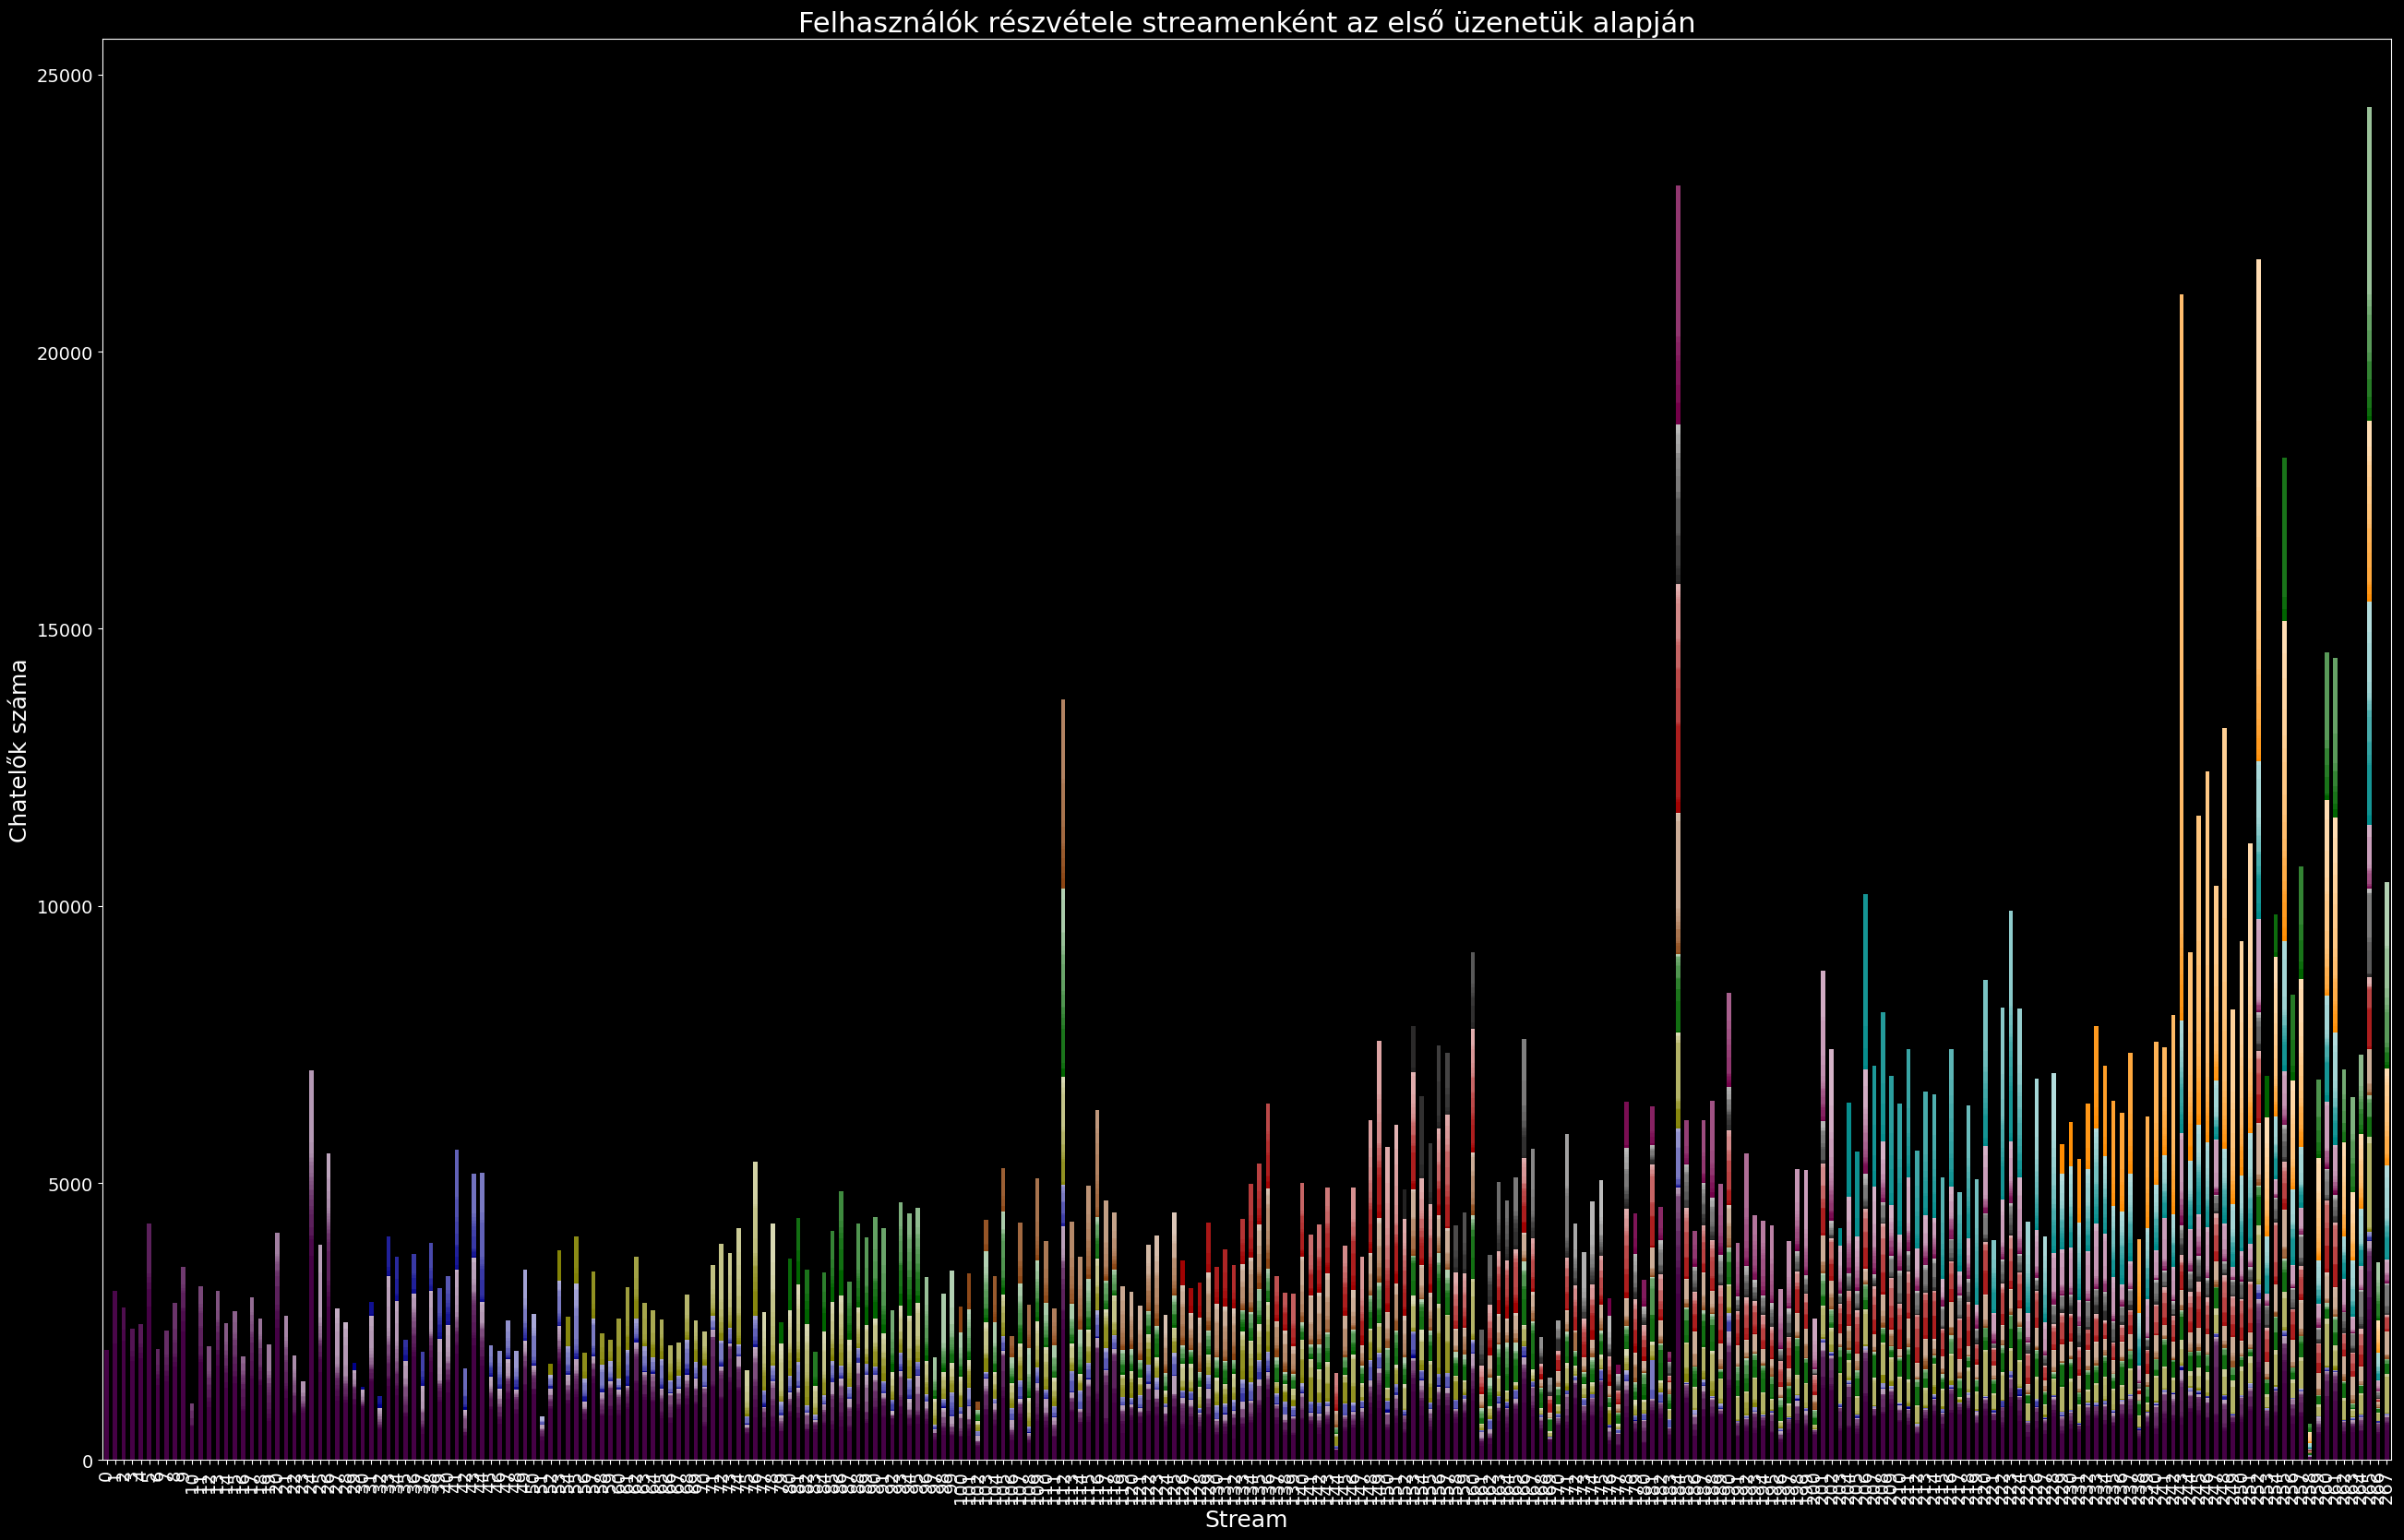

In [12]:
# Plot stacked bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők száma', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

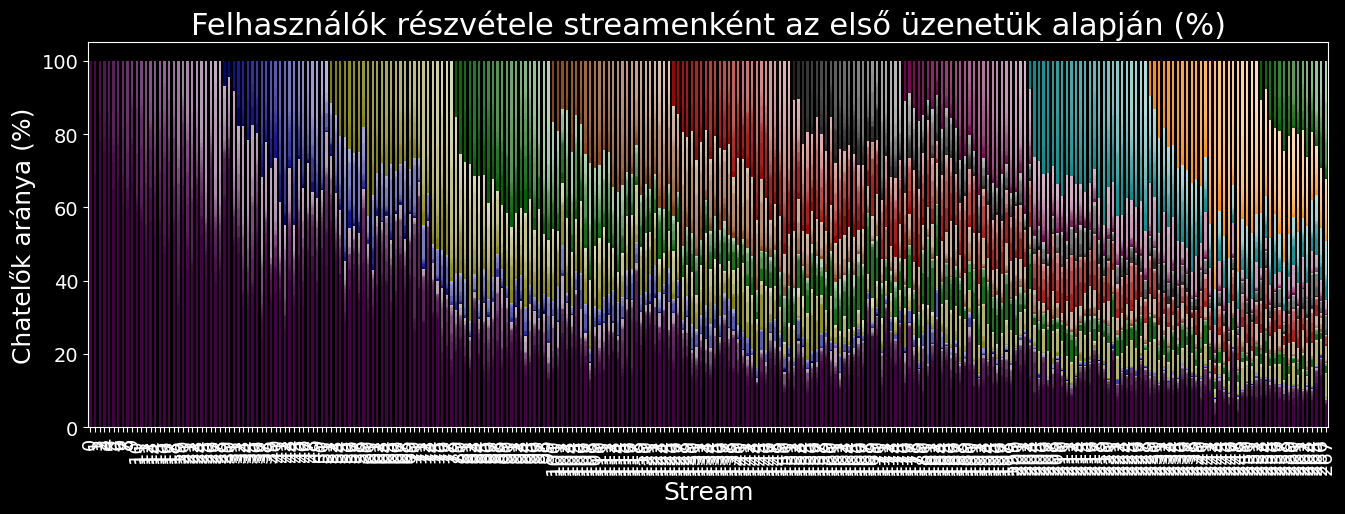

In [13]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot the percentage-based stacked bar chart
fig, ax = plt.subplots(figsize=(16, 5))

pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján (%)', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők aránya (%)', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [14]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,7.816794,0.839695,0.473282,0.045802,0.122137,0.213740,0.000000,0.244275,0.000000,0.244275,...,0.152672,1.450382,4.519084,0.671756,1.526718,10.106870,0.000000,0.000000,0.000000,0.000000
264,7.110625,0.109394,0.150417,0.013674,0.000000,1.025571,0.095720,0.382880,0.027349,0.505948,...,0.027349,1.805005,0.724737,0.642691,1.326405,1.093942,7.821687,0.000000,0.000000,0.000000
265,10.401310,0.716626,0.904996,0.016380,0.000000,1.912367,0.028665,1.138411,0.004095,0.180180,...,0.045045,0.601966,1.621622,1.183456,0.638821,0.470925,0.409500,13.849304,0.000000,0.000000
266,13.329600,0.784094,0.196024,0.056007,0.000000,1.092131,0.532064,0.952114,0.000000,1.064128,...,0.392047,0.980118,1.624195,1.092131,0.616074,2.828339,1.820218,1.624195,8.849062,0.000000
